In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import constants, units
from astropy.coordinates import Angle
from scipy.optimize import curve_fit

In [2]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/MUSE/'

Load in the MUSE FITS file

In [3]:
muse_fits = fits.open(rootdir + 'COMBINED_CUBE_MED_FINAL_vac.fits')

In [4]:
muse_fits.info()

Filename: /Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/MUSE/COMBINED_CUBE_MED_FINAL_vac.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1211   ()      
  1  DATA          1 ImageHDU        42   (337, 319, 3682)   float32   
  2  STAT          1 ImageHDU        43   (337, 319, 3682)   float32   


In [5]:
data_hdu = muse_fits[1]
var_hdu = muse_fits[2]

In [6]:
data_hdu.header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  337 / Axis lenght                                    
NAXIS2  =                  319 / Axis lenght                                    
NAXIS3  =                 3682 / Axis lenght                                    
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'DATA    '           / This extension contains data values            
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'     / version number (according to spec v2.5.1)      
HDUCLAS1= 'IMAGE   '        

In [7]:
var_hdu.header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  337 / Axis lenght                                    
NAXIS2  =                  319 / Axis lenght                                    
NAXIS3  =                 3682 / Axis lenght                                    
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'STAT    '           / This extension contains data variance          
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'     / version number (according to spec v2.5.1)      
HDUCLAS1= 'IMAGE   '        

Extract the MUSE cube as a 3-D array

In [8]:
spec_cube = data_hdu.data.copy()
var_cube = var_hdu.data.copy()

In [9]:
spec_cube.shape, var_cube.shape

((3682, 319, 337), (3682, 319, 337))

Extract the wavelength array

In [10]:
wav_0 = data_hdu.header['CRVAL3']
del_wav = data_hdu.header['CD3_3']

In [11]:
wav_arr = np.arange(wav_0, wav_0 + (spec_cube.shape[0]-1)*del_wav, del_wav)

Extract the RA array

In [12]:
RA_ref_pix = data_hdu.header['CRPIX1']-1
RA_ref_val = data_hdu.header['CRVAL1']
del_RA = data_hdu.header['CD1_1']

In [13]:
RA_0_val = RA_ref_val - del_RA*RA_ref_pix

In [14]:
RA_arr = np.arange(RA_0_val, RA_0_val + spec_cube.shape[2]*del_RA, del_RA)

In [15]:
RA_arr_deg = [Angle(ra, units.degree) for ra in RA_arr]

In [16]:
RA_arr_hms = [ra.hms for ra in RA_arr_deg]

In [17]:
RA_arr_labels = [str(int(ra[0])) + 'h' + str(int(ra[1])) + 'm' + str(np.round(ra[2],2)) + 's' 
                 for ra in RA_arr_hms]

Extract Dec array

In [18]:
Dec_ref_pix = data_hdu.header['CRPIX2']-1
Dec_ref_val = data_hdu.header['CRVAL2']
del_Dec = data_hdu.header['CD2_2']

In [19]:
Dec_0_val = Dec_ref_val - del_Dec*Dec_ref_pix

In [20]:
Dec_arr = np.arange(Dec_0_val, Dec_0_val + spec_cube.shape[1]*del_Dec, del_Dec)

In [21]:
Dec_arr_deg = [Angle(dec, units.degree) for dec in Dec_arr]

In [22]:
Dec_arr_dms = [dec.dms for dec in Dec_arr_deg]

In [23]:
Dec_arr_labels = [str(int(dec[0])) + 'd' + str(int(dec[1])) + 'm' + str(np.round(dec[2],2)) + 's' 
                 for dec in Dec_arr_dms]

First prepare to subtract the QSO light

In [24]:
qso_ref_pix_x = 168 
qso_ref_pix_y = 162

In [25]:
def stack_spec_median(r_a, r_b):

    circ_x_a = [qso_ref_pix_x + r_a*np.cos(p) for p in np.linspace(0, 2*np.pi, 100)]
    circ_y_a = [qso_ref_pix_y + r_a*np.sin(p) for p in np.linspace(0, 2*np.pi, 100)]

    circ_x_b = [qso_ref_pix_x + r_b*np.cos(p) for p in np.linspace(0, 2*np.pi, 100)]
    circ_y_b = [qso_ref_pix_y + r_b*np.sin(p) for p in np.linspace(0, 2*np.pi, 100)]

    pixel_x_arr = []
    pixel_y_arr = []

    for i in range(spec_cube.shape[2]):
        for j in range(spec_cube.shape[1]):

            d = np.sqrt((i-qso_ref_pix_x)**2 + (j-qso_ref_pix_y)**2)

            if(d>=r_a and d<=r_b):
                pixel_x_arr.append(i)
                pixel_y_arr.append(j)
    
    spec_stack = np.zeros((len(pixel_x_arr), len(wav_arr)))
    var_stack = np.zeros((len(pixel_x_arr), len(wav_arr)))
    
    for i in range(len(pixel_x_arr)):

        x = pixel_x_arr[i]
        y = pixel_y_arr[i]

        spec_stack[i,:] = spec_cube[:, y, x]
        var_stack[i,:] = var_cube[:, y, x]
        
    spec_master = np.nanmean(spec_stack, axis=0)
    err_master = np.sqrt(np.nansum(var_stack, axis=0))/len(pixel_x_arr)
    
    return circ_x_a, circ_y_a, circ_x_b, circ_y_b, spec_master, err_master

In [26]:
r_lo = [0, 1, 2, 3, 5, 7]
r_hi = [1, 2, 3, 4, 6, 10]

In [27]:
circ_x_lo = []
circ_y_lo = []

circ_x_hi = []
circ_y_hi = []

spec_master_arr = []
err_master_arr = []

In [28]:
for i in range(len(r_lo)):
    
    r_a = r_lo[i]
    r_b = r_hi[i]
    circ_x_a, circ_y_a, circ_x_b, circ_y_b, spec_master, err_master = stack_spec_median(r_a, r_b)
    
    circ_x_lo.append(circ_x_a)
    circ_y_lo.append(circ_y_a)

    circ_x_hi.append(circ_x_b)
    circ_y_hi.append(circ_y_b)
    
    spec_master_arr.append(spec_master)
    err_master_arr.append(err_master)

In [29]:
f_a = spec_master_arr[0]
f_b = spec_master_arr[4]

In [30]:
def best_model(f, f_err):
    
    alpha = np.nansum(f_a**2/f_err**2)
    beta = np.nansum(f_a*f_b/f_err**2)
    gamma = np.nansum(f_b**2/f_err**2)
    
    kappa = np.nansum(f*f_a/f_err**2)
    nu = np.nansum(f*f_b/f_err**2)
    
    a = (kappa*gamma-nu*beta)/(alpha*gamma-beta**2)
    b = (kappa*beta-alpha*nu)/(beta**2-alpha*gamma)
    
    return a, b

In [31]:
f = spec_cube[:,qso_ref_pix_y+2,qso_ref_pix_x-2]
f_err = np.sqrt(var_cube[:,qso_ref_pix_y+2,qso_ref_pix_x-2])

In [32]:
a, b = best_model(f, f_err)

In [33]:
r=15

In [34]:
disc_x_pix = []
disc_y_pix = []

for i in range(spec_cube.shape[2]):
    for j in range(spec_cube.shape[1]):

        d = np.sqrt((i-qso_ref_pix_x)**2 + (j-qso_ref_pix_y)**2)

        if(d<=r):
            disc_x_pix.append(i)
            disc_y_pix.append(j)

In [35]:
a_disc = []
b_disc = []

In [36]:
for i in range(len(disc_x_pix)):
    
    x = disc_x_pix[i]
    y = disc_y_pix[i]
    
    f = spec_cube[:,y,x]
    f_err = np.sqrt(var_cube[:,y,x])
    
    a, b = best_model(f, f_err)
    
    a_disc.append(a)
    b_disc.append(b)

Next prepare to subtract the galaxy light

In [37]:
seg_fits = fits.open(rootdir+'test_seg.fits')

In [38]:
seg_map = seg_fits[0].data

In [39]:
gal_1_x_pix = 155
gal_1_y_pix = 184

gal_1_id = seg_map[gal_1_y_pix, gal_1_x_pix]
seg_map_gal_1_y, seg_map_gal_1_x = np.where(seg_map==gal_1_id)

In [40]:
gal_2_x_pix = 146
gal_2_y_pix = 203

gal_2_id = seg_map[gal_2_y_pix, gal_2_x_pix]
seg_map_gal_2_y, seg_map_gal_2_x = np.where(seg_map==gal_2_id)

In [41]:
flux_gal_1 = np.zeros(len(seg_map_gal_1_x))

for i in range(len(seg_map_gal_1_x)):
    
    x = seg_map_gal_1_x[i]
    y = seg_map_gal_1_y[i]
    
    flux_gal_1[i] = np.nansum(spec_cube[:,y,x])

In [42]:
flux_gal_2 = np.zeros(len(seg_map_gal_2_x))

for i in range(len(seg_map_gal_2_x)):
    
    x = seg_map_gal_2_x[i]
    y = seg_map_gal_2_y[i]
    
    flux_gal_2[i] = np.nansum(spec_cube[:,y,x])

In [43]:
min_flux_gal_1 = np.nanpercentile(flux_gal_1, 65)
max_flux_gal_1 = np.nanpercentile(flux_gal_1, 100)

idx_gal_1 = (flux_gal_1>=min_flux_gal_1) & (flux_gal_1<=max_flux_gal_1)

In [44]:
min_flux_gal_2 = np.nanpercentile(flux_gal_2, 78)
max_flux_gal_2 = np.nanpercentile(flux_gal_2, 100)

idx_gal_2 = (flux_gal_2>=min_flux_gal_2) & (flux_gal_2<=max_flux_gal_2)

In [45]:
spec_stack_1 = np.zeros((len(seg_map_gal_1_x), len(wav_arr)))
var_stack_1 = np.zeros((len(seg_map_gal_1_x), len(wav_arr)))

for i in range(len(seg_map_gal_1_x)):
    
    x = seg_map_gal_1_x[i]
    y = seg_map_gal_1_y[i]
    
    spec_stack_1[i,:] = spec_cube[:,y,x]
    var_stack_1[i,:] = var_cube[:,y,x]
    
spec_master_1 = np.nanmean(spec_stack_1[idx_gal_1], axis=0)
spec_master_err_1 = np.sqrt(np.nansum(var_stack_1[idx_gal_1], axis=0))/np.sum(idx_gal_1)

In [46]:
np.savetxt(rootdir + 'gal_1_master.dat',
              np.vstack((wav_arr, spec_master_1, spec_master_err_1)).T, delimiter='\t')

In [47]:
spec_stack_2 = np.zeros((len(seg_map_gal_2_x), len(wav_arr)))
var_stack_2 = np.zeros((len(seg_map_gal_2_x), len(wav_arr)))

for i in range(len(seg_map_gal_2_x)):
    
    x = seg_map_gal_2_x[i]
    y = seg_map_gal_2_y[i]
    
    spec_stack_2[i,:] = spec_cube[:,y,x]
    var_stack_2[i,:] = var_cube[:,y,x]
    
spec_master_2 = np.nanmean(spec_stack_2[idx_gal_2], axis=0)
spec_master_err_2 = np.sqrt(np.nansum(var_stack_2[idx_gal_2], axis=0))/np.sum(idx_gal_2)

In [48]:
np.savetxt(rootdir + 'gal_2_master.dat',
              np.vstack((wav_arr, spec_master_2, spec_master_err_2)).T, delimiter='\t')

In [49]:
def scale_off(f, a, b):
    return a*f + b

In [50]:
apply_offset = True

In [51]:
a_gal_1 = []
b_gal_1 = []

for i in range(len(seg_map_gal_1_x)):
    
    x = seg_map_gal_1_x[i]
    y = seg_map_gal_1_y[i]
    
    f = spec_cube[:,y,x]
    
    idx = ~(np.isnan(f) | np.isnan(spec_master_1))
    
    if(apply_offset == True):
        opt, covar = curve_fit(scale_off, spec_master_1[idx], f[idx])
        b_gal_1.append(opt[1])
    else:
        opt, covar = curve_fit(lambda f, a: scale_off(f, a, 0), spec_master_1[idx], f[idx])
        b_gal_1.append(0)
    
    a_gal_1.append(opt[0])

In [52]:
a_gal_2 = []
b_gal_2 = []

for i in range(len(seg_map_gal_2_x)):
    
    x = seg_map_gal_2_x[i]
    y = seg_map_gal_2_y[i]
    
    f = spec_cube[:,y,x]
    
    idx = ~(np.isnan(f) | np.isnan(spec_master_2))
    
    if(apply_offset == True):
        opt, covar = curve_fit(scale_off, spec_master_2[idx], f[idx])
        b_gal_2.append(opt[1])
    else:
        opt, covar = curve_fit(lambda f, a: scale_off(f, a, 0), spec_master_2[idx], f[idx])
        b_gal_2.append(0)
    
    a_gal_2.append(opt[0])

Now actually subtract out things

In [53]:
spec_cube_sub = data_hdu.data.copy()

In [54]:
for i in range(len(disc_x_pix)):
    
    x = disc_x_pix[i]
    y = disc_y_pix[i]
    
    spec_cube_sub[:,y,x] -= (a_disc[i]*f_a + b_disc[i]*f_b)

In [55]:
for i in range(len(seg_map_gal_1_x)):
    
    x = seg_map_gal_1_x[i]
    y = seg_map_gal_1_y[i]
    
    spec_cube_sub[:,y,x] -= a_gal_1[i]*spec_master_1+b_gal_1[i]

In [56]:
for i in range(len(seg_map_gal_2_x)):
    
    x = seg_map_gal_2_x[i]
    y = seg_map_gal_2_y[i]
    
    spec_cube_sub[:,y,x] -= a_gal_2[i]*spec_master_2+b_gal_2[i]

In [57]:
wav_slice_idx = np.arange(0, len(wav_arr), 500)
wav_slice = wav_arr[wav_slice_idx]

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_21173/1616615323.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(RA_arr_labels[qso_ref_pix_x-qso_window_pix:qso_ref_pix_x+qso_window_pix],
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_21173/1616615323.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(Dec_arr_labels[qso_ref_pix_x-qso_window_pix:qso_ref_pix_x+qso_window_pix], fontsize=13)


Text(0, 0.5, 'Declination (dms)')

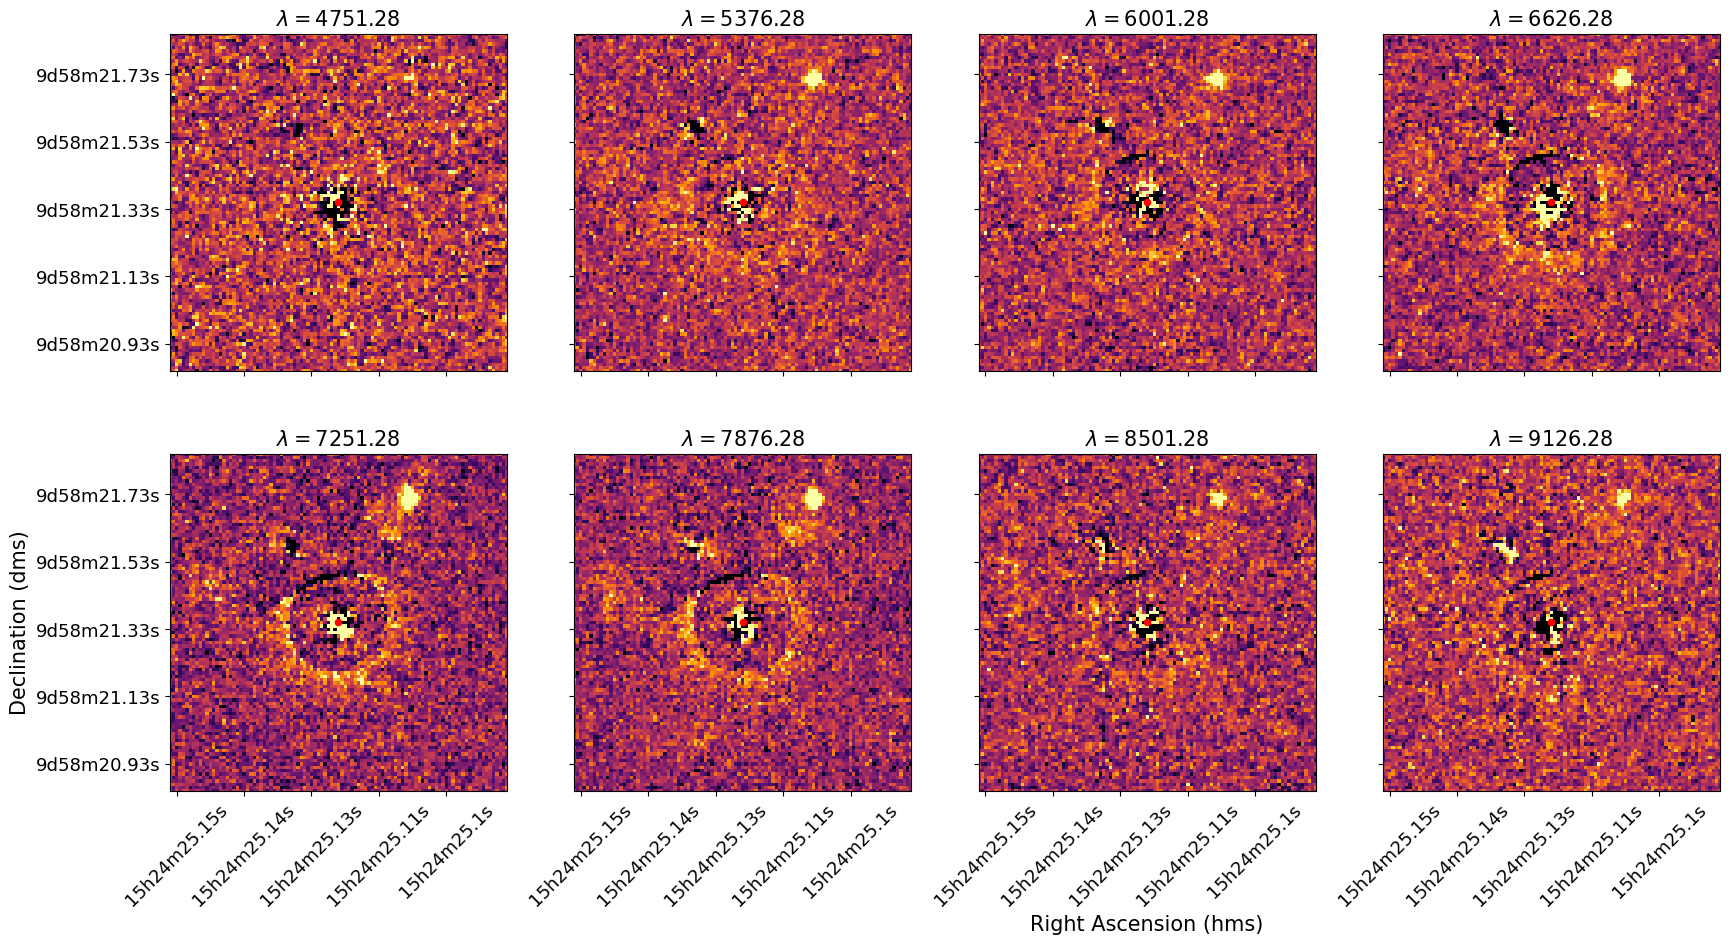

In [58]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex = True, sharey=True)

for i in range(len(wav_slice)):
    wav_idx = wav_slice_idx[i]
    wav = wav_slice[i]
    ax = axes[i//4][i%4]
    
    qso_window_pix = 50
    
    spec_arr_sub = spec_cube_sub[wav_idx,:,:]
    
    spec_arr_sub_flat = spec_arr_sub.flatten()
    min_flux_sub = np.nanpercentile(spec_arr_sub_flat, 1)
    max_flux_sub = np.nanpercentile(spec_arr_sub_flat, 99)

    ax.imshow(spec_arr_sub, vmin = min_flux_sub, vmax = max_flux_sub, cmap='inferno')

    ax.scatter(qso_ref_pix_x, qso_ref_pix_y, color='red', s=20)

    ax.set_title(r'$\lambda = $' + str(np.round(wav, 2)), fontsize=15)
    ax.set_xticklabels(RA_arr_labels[qso_ref_pix_x-qso_window_pix:qso_ref_pix_x+qso_window_pix], 
                       rotation=45, fontsize=13)
    ax.set_yticklabels(Dec_arr_labels[qso_ref_pix_x-qso_window_pix:qso_ref_pix_x+qso_window_pix], fontsize=13)


    ax.set_xlim(qso_ref_pix_x-qso_window_pix, qso_ref_pix_x+qso_window_pix)
    ax.set_ylim(qso_ref_pix_y+qso_window_pix, qso_ref_pix_y-qso_window_pix)

    ax.invert_yaxis()
    
axes[1,2].set_xlabel('Right Ascension (hms)', fontsize=15, position=(0,1))
axes[1,0].set_ylabel('Declination (dms)', fontsize=15, position=(0,1))

Write out the datacube

In [59]:
data_sub_hdu = fits.ImageHDU(spec_cube_sub)

In [60]:
data_sub_hdu.header = data_hdu.header

In [61]:
hdu = fits.HDUList([muse_fits[0], data_sub_hdu, muse_fits[2]])

In [62]:
hdu.writeto(rootdir +'COMBINED_CUBE_MED_FINAL_vac_sub_15_pix.fits')